Starting Monte Carlo sampling...


MC Sampling: 100%|██████████| 50000/50000 [02:59<00:00, 278.47it/s]


Monte Carlo acceptance rate: 0.0588

Starting MCMC sampling...


MCMC Sampling: 100%|██████████| 50000/50000 [01:45<00:00, 473.90it/s]


MCMC acceptance rate: 0.6299


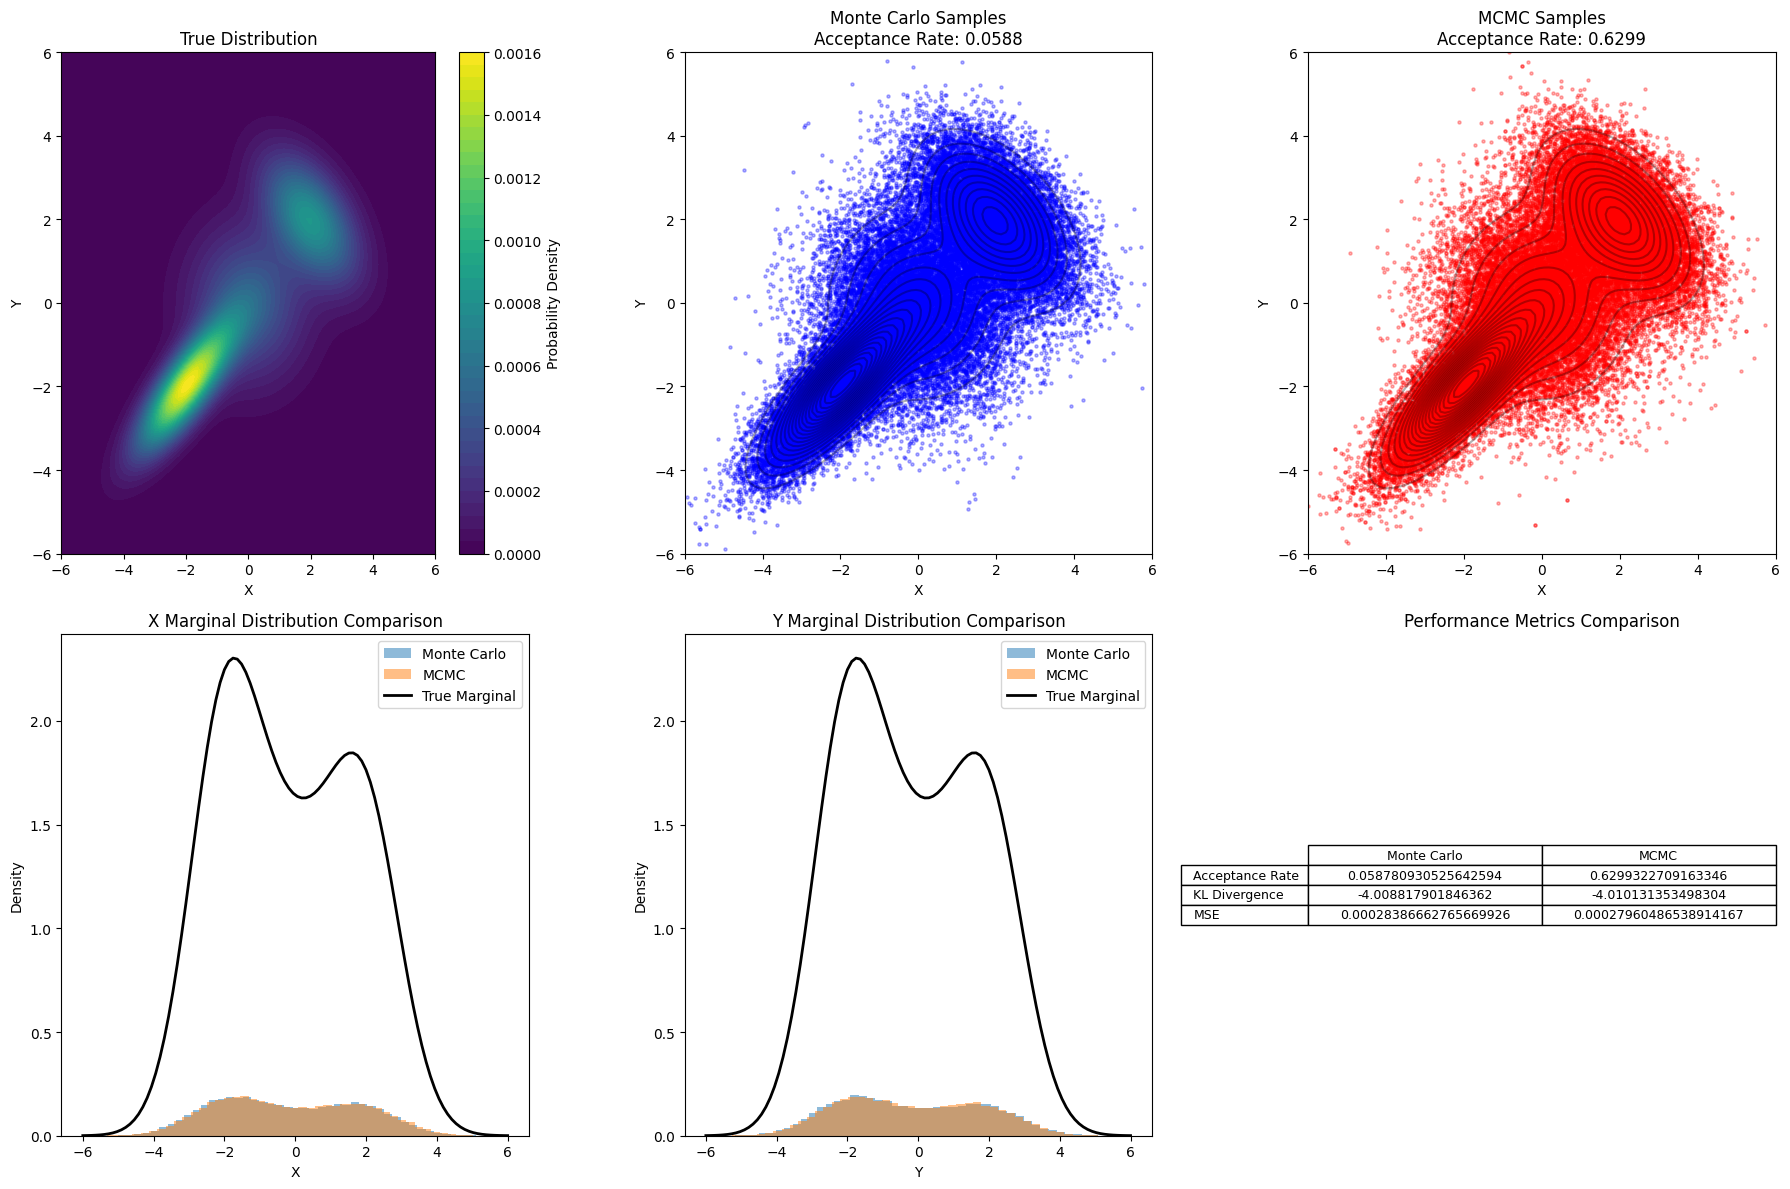

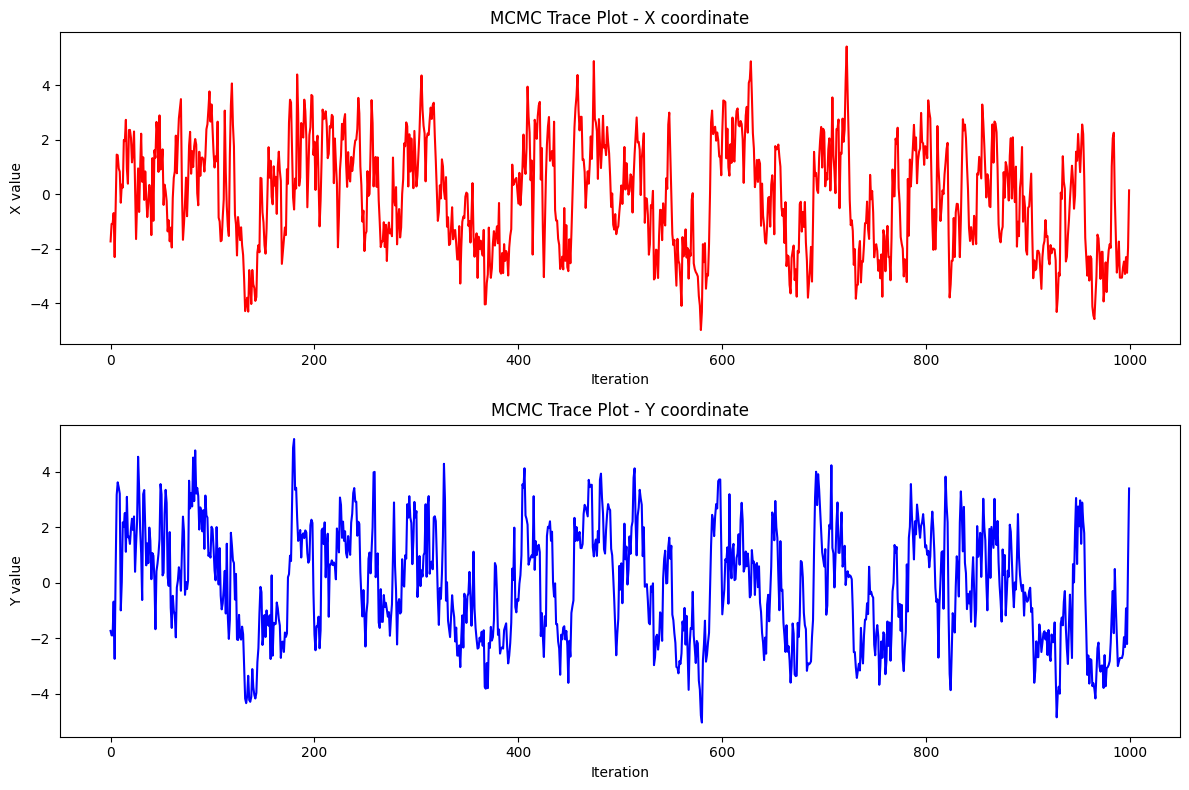

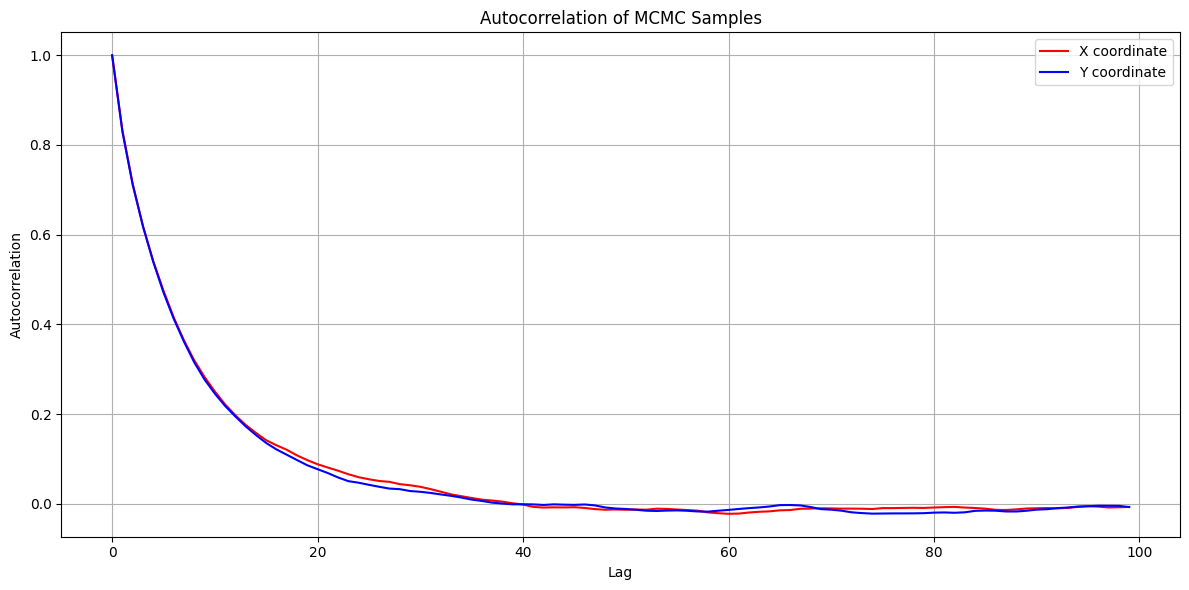

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
from matplotlib import cm
from matplotlib.colors import ListedColormap
from tqdm import tqdm

# Set random seed for reproducibility
np.random.seed(42)

# Define a complicated multimodal distribution for grid evaluation
def target_pdf(x, y):
    """
    A complicated multimodal distribution defined as a mixture of three 2D Gaussians
    For grid evaluation
    """
    # Convert inputs to a 2D array of points
    points = np.column_stack([x.flatten(), y.flatten()])
    
    # First Gaussian
    mu1 = np.array([-2.0, -2.0])
    sigma1 = np.array([[1.0, 0.8], [0.8, 1.0]])
    g1 = stats.multivariate_normal.pdf(points, mean=mu1, cov=sigma1)
    
    # Second Gaussian
    mu2 = np.array([2.0, 2.0])
    sigma2 = np.array([[1.0, -0.5], [-0.5, 1.0]])
    g2 = stats.multivariate_normal.pdf(points, mean=mu2, cov=sigma2)
    
    # Third Gaussian
    mu3 = np.array([0.0, 0.0])
    sigma3 = np.array([[1.5, 0.0], [0.0, 1.5]])
    g3 = stats.multivariate_normal.pdf(points, mean=mu3, cov=sigma3)
    
    # Mixture with different weights
    result = 0.4 * g1 + 0.3 * g2 + 0.3 * g3
    
    # Reshape back to original dimensions
    return result.reshape(x.shape)

# Create a grid for visualization
grid_resolution = 100
x = np.linspace(-6, 6, grid_resolution)
y = np.linspace(-6, 6, grid_resolution)
X, Y = np.meshgrid(x, y)

# Calculate density at each grid point
Z = target_pdf(X, Y)

# Normalize Z to make it a proper probability distribution
Z = Z / np.sum(Z)

# Flatten grid points into array of coordinates for sampling
coords = np.vstack([X.ravel(), Y.ravel()]).T
pdf_values = Z.ravel()

# Function to evaluate PDF at a single point
def target_pdf_single(point):
    """
    Evaluate the target PDF at a single point.
    
    Args:
        point: A 1D array or list with [x, y] coordinates
        
    Returns:
        float: The probability density at that point
    """
    x, y = point
    
    # First Gaussian
    mu1 = np.array([-2.0, -2.0])
    sigma1 = np.array([[1.0, 0.8], [0.8, 1.0]])
    g1 = stats.multivariate_normal.pdf([x, y], mean=mu1, cov=sigma1)
    
    # Second Gaussian
    mu2 = np.array([2.0, 2.0])
    sigma2 = np.array([[1.0, -0.5], [-0.5, 1.0]])
    g2 = stats.multivariate_normal.pdf([x, y], mean=mu2, cov=sigma2)
    
    # Third Gaussian
    mu3 = np.array([0.0, 0.0])
    sigma3 = np.array([[1.5, 0.0], [0.0, 1.5]])
    g3 = stats.multivariate_normal.pdf([x, y], mean=mu3, cov=sigma3)
    
    # Mixture with different weights
    return 0.4 * g1 + 0.3 * g2 + 0.3 * g3

# Function for Monte Carlo sampling
def monte_carlo_sampling(n_samples):
    """
    Simple Monte Carlo sampling using rejection sampling
    """
    samples = []
    attempts = 0
    
    # Calculate max_pdf more reliably by sampling from a grid
    grid_samples = []
    for _ in range(1000):
        x_temp = np.random.uniform(-6, 6)
        y_temp = np.random.uniform(-6, 6)
        grid_samples.append(target_pdf_single([x_temp, y_temp]))
    max_pdf = max(grid_samples) * 1.1  # Add 10% for safety
    
    with tqdm(total=n_samples, desc="MC Sampling") as pbar:
        while len(samples) < n_samples:
            attempts += 1
            # Propose from uniform distribution
            x_prop = np.random.uniform(-6, 6)
            y_prop = np.random.uniform(-6, 6)
            
            # Calculate probability
            p = target_pdf_single([x_prop, y_prop])
            
            # Accept with probability p/max_pdf
            if np.random.uniform(0, max_pdf) <= p:
                samples.append([x_prop, y_prop])
                pbar.update(1)
    
    acceptance_rate = n_samples / attempts
    return np.array(samples), acceptance_rate

# Function for Metropolis-Hastings MCMC
def mcmc_sampling(n_samples, burnin=1000, thin=5):
    """
    MCMC sampling using Metropolis-Hastings algorithm
    """
    samples = []
    x_current = np.array([np.random.uniform(-6, 6), np.random.uniform(-6, 6)])  # Starting point
    proposal_std = 0.8  # Step size for proposal
    accepted = 0
    total = 0
    
    # Burn-in phase
    for _ in range(burnin):
        x_proposed = x_current + np.random.normal(0, proposal_std, 2)
        
        # Calculate acceptance probability
        current_density = target_pdf_single(x_current)
        proposed_density = target_pdf_single(x_proposed)
        
        # Metropolis-Hastings acceptance ratio
        acceptance_ratio = proposed_density / current_density if current_density > 0 else 1
        
        # Accept or reject
        if np.random.uniform() < acceptance_ratio:
            x_current = x_proposed
            accepted += 1
        total += 1
    
    # Sampling phase with thinning
    with tqdm(total=n_samples, desc="MCMC Sampling") as pbar:
        while len(samples) < n_samples:
            for _ in range(thin):
                x_proposed = x_current + np.random.normal(0, proposal_std, 2)
                
                # Calculate acceptance probability
                current_density = target_pdf_single(x_current)
                proposed_density = target_pdf_single(x_proposed)
                
                # Metropolis-Hastings acceptance ratio
                acceptance_ratio = proposed_density / current_density if current_density > 0 else 1
                
                # Accept or reject
                if np.random.uniform() < acceptance_ratio:
                    x_current = x_proposed
                    accepted += 1
                total += 1
            
            samples.append(x_current.copy())
            pbar.update(1)
    
    acceptance_rate = accepted / total
    return np.array(samples), acceptance_rate

# Sample from the distribution using both methods
n_samples = 50000
print("Starting Monte Carlo sampling...")
mc_samples, mc_rate = monte_carlo_sampling(n_samples)
print(f"Monte Carlo acceptance rate: {mc_rate:.4f}")

print("\nStarting MCMC sampling...")
mcmc_samples, mcmc_rate = mcmc_sampling(n_samples)
print(f"MCMC acceptance rate: {mcmc_rate:.4f}")

# Compare the samples to the true distribution

# Create custom colormap for better visualization
colors = plt.cm.viridis(np.linspace(0, 1, 256))
mymap = ListedColormap(colors)

# Visualize the true distribution and samples
plt.figure(figsize=(18, 12))

# True Distribution
plt.subplot(2, 3, 1)
plt.contourf(X, Y, Z, 50, cmap=mymap)
plt.colorbar(label='Probability Density')
plt.title('True Distribution')
plt.xlabel('X')
plt.ylabel('Y')

# Monte Carlo Samples
plt.subplot(2, 3, 2)
plt.scatter(mc_samples[:, 0], mc_samples[:, 1], alpha=0.3, s=5, c='blue')
plt.contour(X, Y, Z, 20, colors='black', alpha=0.3)
plt.title(f'Monte Carlo Samples\nAcceptance Rate: {mc_rate:.4f}')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(-6, 6)
plt.ylim(-6, 6)

# MCMC Samples
plt.subplot(2, 3, 3)
plt.scatter(mcmc_samples[:, 0], mcmc_samples[:, 1], alpha=0.3, s=5, c='red')
plt.contour(X, Y, Z, 20, colors='black', alpha=0.3)
plt.title(f'MCMC Samples\nAcceptance Rate: {mcmc_rate:.4f}')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(-6, 6)
plt.ylim(-6, 6)

# Density Comparison - X Marginal
plt.subplot(2, 3, 4)
# Compute true marginal along x
true_x_marginal = np.sum(Z, axis=0)
true_x_marginal = true_x_marginal / np.sum(true_x_marginal)  # Normalize

# Histogram of x-coordinates from samples
plt.hist(mc_samples[:, 0], bins=50, density=True, alpha=0.5, label='Monte Carlo')
plt.hist(mcmc_samples[:, 0], bins=50, density=True, alpha=0.5, label='MCMC')
plt.plot(x, true_x_marginal * len(x) / np.sum(true_x_marginal), 'k-', linewidth=2, label='True Marginal')
plt.title('X Marginal Distribution Comparison')
plt.xlabel('X')
plt.ylabel('Density')
plt.legend()

# Density Comparison - Y Marginal
plt.subplot(2, 3, 5)
# Compute true marginal along y
true_y_marginal = np.sum(Z, axis=1)
true_y_marginal = true_y_marginal / np.sum(true_y_marginal)  # Normalize

# Histogram of y-coordinates from samples
plt.hist(mc_samples[:, 1], bins=50, density=True, alpha=0.5, label='Monte Carlo')
plt.hist(mcmc_samples[:, 1], bins=50, density=True, alpha=0.5, label='MCMC')
plt.plot(y, true_y_marginal * len(y) / np.sum(true_y_marginal), 'k-', linewidth=2, label='True Marginal')
plt.title('Y Marginal Distribution Comparison')
plt.xlabel('Y')
plt.ylabel('Density')
plt.legend()

# Calculate metrics for both methods
def calculate_metrics(samples, grid_resolution=100):
    # Calculate histogram of samples
    hist, x_edges, y_edges = np.histogram2d(
        samples[:, 0], samples[:, 1], 
        bins=grid_resolution, 
        range=[[-6, 6], [-6, 6]], 
        density=True
    )
    
    # Replace zeros with small value to avoid division by zero or log(0)
    hist_safe = np.maximum(hist, 1e-10)
    Z_safe = np.maximum(Z, 1e-10)
    
    # Calculate KL divergence: ∑ P(x) * log(P(x)/Q(x))
    # Where P is true distribution and Q is approximation
    kl_div = np.sum(Z_safe * np.log(Z_safe/hist_safe))
    
    # Calculate Mean Squared Error
    mse = np.mean((Z - hist) ** 2)
    
    return {'KL Divergence': kl_div, 'MSE': mse}

# Calculate metrics
metrics_mc = calculate_metrics(mc_samples)
metrics_mcmc = calculate_metrics(mcmc_samples)

# Display metrics in a table
metrics_df = pd.DataFrame({
    'Monte Carlo': [mc_rate, metrics_mc['KL Divergence'], metrics_mc['MSE']], 
    'MCMC': [mcmc_rate, metrics_mcmc['KL Divergence'], metrics_mcmc['MSE']]
}, index=['Acceptance Rate', 'KL Divergence', 'MSE'])

plt.subplot(2, 3, 6)
plt.axis('off')
plt.table(cellText=metrics_df.values, 
          rowLabels=metrics_df.index, 
          colLabels=metrics_df.columns, 
          loc='center',
          cellLoc='center')
plt.title('Performance Metrics Comparison')

plt.tight_layout()
plt.savefig('mc_vs_mcmc_comparison.png', dpi=300)
plt.show()

# Additional visualization: Trace plots for MCMC (first 1000 samples)
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(mcmc_samples[:1000, 0], 'r-')
plt.title('MCMC Trace Plot - X coordinate')
plt.xlabel('Iteration')
plt.ylabel('X value')

plt.subplot(2, 1, 2)
plt.plot(mcmc_samples[:1000, 1], 'b-')
plt.title('MCMC Trace Plot - Y coordinate')
plt.xlabel('Iteration')
plt.ylabel('Y value')

plt.tight_layout()
plt.savefig('mcmc_trace_plots.png', dpi=300)
plt.show()

# Autocorrelation plots for MCMC samples
def autocorrelation(x, maxlag):
    result = np.zeros(maxlag)
    x = x - np.mean(x)
    var = np.var(x)
    for lag in range(maxlag):
        result[lag] = np.sum(x[lag:] * x[:-lag if lag > 0 else None]) / (len(x) * var)
    return result

plt.figure(figsize=(12, 6))

max_lag = 100
acf_x = autocorrelation(mcmc_samples[:, 0], max_lag)
acf_y = autocorrelation(mcmc_samples[:, 1], max_lag)

plt.plot(range(max_lag), acf_x, 'r-', label='X coordinate')
plt.plot(range(max_lag), acf_y, 'b-', label='Y coordinate')
plt.title('Autocorrelation of MCMC Samples')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('mcmc_autocorrelation.png', dpi=300)
plt.show()